# Laboratorio de Aprendizaje por Refuerzo - Frozen Lake

### Integrantes:
- Flores Medina Erik Daniel  
- Gutierrez Coronado Matias Ezequiel

## 1. Introducción

En este laboratorio se analiza el equilibrio entre **exploración y explotación** en el contexto del aprendizaje por refuerzo, utilizando el entorno `FrozenLake-v1` de la librería Gymnasium. El estudio se centra en la implementación de cuatro técnicas clave extraídas del cuadernillo **02_bandits.ipynb** del autor Sensio:

- Implementacion incremental
- Valores iniciales Optimistas
- Seleccion de acciones con intervalo de confianza
- Algoritmo de Gradiente

## 2. Entorno Seleccionado: FrozenLake-v1

**FrozenLake** es un entorno clásico de la librería Gymnasium. Simula un lago congelado con casillas resbaladizas, donde el objetivo es alcanzar la meta evitando los agujeros.

**Características del entorno:**

| Parámetro        | Valor utilizado      |
|------------------|----------------------|
| `map_name`       | `"8x8"`              |
| `is_slippery`    | `False`              |
| `render_mode`    | `None` (modo texto)  |
| `length of the episode` | 200              |

El entorno se configura sin resbalones (`is_slippery=False`) para asegurar que las decisiones del agente tengan un resultado determinista. Esto facilita el análisis comparativo entre estrategias.


In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

### 🧪 Entornos utilizados


#### 1. `env` — Entorno de entrenamiento
- Este entorno **no incluye `render_mode`**, ya que durante el entrenamiento:
  - No necesitamos visualizar gráficamente cada acción del agente.
  - El enfoque está en la exploración y explotación eficiente.
  - El renderizado ralentiza el proceso, lo cual no es deseable cuando se ejecutan miles de episodios.

#### 2. `env_prueba` — Entorno de prueba
- Este entorno **sí incluye `render_mode="human"`** porque:
  - Queremos observar visualmente cómo se comporta el agente **una vez entrenado**.
  - La explotación se realiza al **100%**, es decir, el agente siempre elige su mejor acción conocida.
  - Es útil para verificar que el agente aprendió una estrategia efectiva y consistente.

In [2]:
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
#env_prueba = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="human")

n_estados = env.observation_space.n
n_acciones = env.action_space.n

print(f"Numeros de estados: {n_estados}, Numero de acciones: {n_acciones}")




Numeros de estados: 64, Numero de acciones: 4


In [3]:
# Función para media móvil
def media_movil(x, ventana=100):
    return np.convolve(x, np.ones(ventana)/ventana, mode='valid')


In [4]:
RECOMPENSAS = {
    "META": 1.0,
    "HUECO": -1.0,
    "ESTANCADO": -0.5,
    "REPETIDO": -0.4,
    "AVANCE": -0.3,
    #"MOVIMIENTO_CIEGO": -0.01
}

#### Observar el escenario

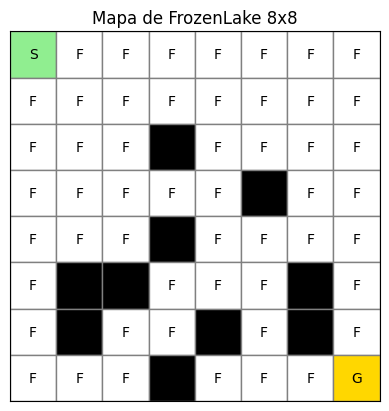

In [5]:
desc = env.unwrapped.desc.astype(str)

color_map = {
    'S': 'lightgreen',
    'F': 'white',
    'H': 'black',
    'G': 'gold'
}

fig, ax = plt.subplots()
for i in range(desc.shape[0]):
    for j in range(desc.shape[1]):
        tipo = desc[i, j]
        color = color_map.get(tipo, 'gray')
        ax.add_patch(plt.Rectangle((j, 7 - i), 1, 1, facecolor=color, edgecolor='gray'))
        ax.text(j + 0.5, 7 - i + 0.5, tipo, ha='center', va='center')

ax.set_xlim(0, 8)
ax.set_ylim(0, 8)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
plt.title("Mapa de FrozenLake 8x8")
plt.show()

## Implementacion incremental

In [6]:
class ActorIncremental:
    def __init__(self, n_estados, n_acciones, alpha):
        self.q_values = np.zeros((n_estados, n_acciones))  # Q inicia en cero
        self.alpha = alpha
        self.n_acciones = n_acciones

    def seleccionar_accion(self, estado, epsilon):
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_acciones)  # Exploración
        q = self.q_values[estado]
        max_q = np.max(q)
        acciones_mejores = np.flatnonzero(q == max_q)
        return np.random.choice(acciones_mejores)  # Explotación

    def actualizar(self, estado, accion, recompensa):
        actual = self.q_values[estado, accion]
        self.q_values[estado, accion] += self.alpha * (recompensa - actual)

    def explotar(self, estado):
        q = self.q_values[estado]
        max_q = np.max(q)
        acciones_mejores = np.flatnonzero(q == max_q)
        return np.random.choice(acciones_mejores)


In [7]:
epsilons = [0.0, 0.01, 0.1, 0.3, 0.5, 1.0]
episodios = 6000
resultados_por_epsilon = {}
actores_incrementales = []


for epsilon in epsilons:
    actor = ActorIncremental(n_estados, n_acciones, alpha=0.3)
    actores_incrementales.append(actor)
    lista_recompensas = []

    for episodio in range(episodios):
        estado, _ = env.reset()
        terminado = False
        visitados = set([estado])
        recompensa_total_real = 0

        while not terminado:
            accion = actor.seleccionar_accion(estado, epsilon=epsilon)
            siguiente_estado, recompensa_real, terminado, truncado, _ = env.step(accion)

            if recompensa_real == 1.0:
                recompensa = RECOMPENSAS["META"]
            elif terminado and recompensa_real == 0.0:
                recompensa = RECOMPENSAS["HUECO"]
            elif siguiente_estado == estado:
                recompensa = RECOMPENSAS["ESTANCADO"]
            elif siguiente_estado in visitados:
                recompensa = RECOMPENSAS["REPETIDO"]
            else:
                recompensa = RECOMPENSAS["AVANCE"]
                visitados.add(siguiente_estado)

            actor.actualizar(estado, accion, recompensa)
            estado = siguiente_estado
            recompensa_total_real += recompensa_real

        lista_recompensas.append(recompensa_total_real)

    resultados_por_epsilon[epsilon] = lista_recompensas


In [8]:
acciones = ["←", "↓", "→", "↑"]
q_table_df = pd.DataFrame(actores_incrementales[0].q_values, columns=acciones)
q_table_df.index.name = "Estado"

print("\n📋 Q-table final del actor incremental:\n")
print(q_table_df.round(2))



📋 Q-table final del actor incremental:

           ←     ↓     →     ↑
Estado                        
0      -0.38 -0.30 -0.36 -0.38
1      -0.38 -0.39 -0.37 -0.42
2      -0.38 -0.38 -0.37 -0.42
3      -0.37 -0.37 -0.37 -0.38
4      -0.37 -0.38 -0.35 -0.38
...      ...   ...   ...   ...
59      0.00  0.00  0.00  0.00
60      0.00  0.00 -0.12 -0.30
61     -0.15 -0.26 -0.20 -0.20
62      0.00  0.00  0.66  0.00
63      0.00  0.00  0.00  0.00

[64 rows x 4 columns]


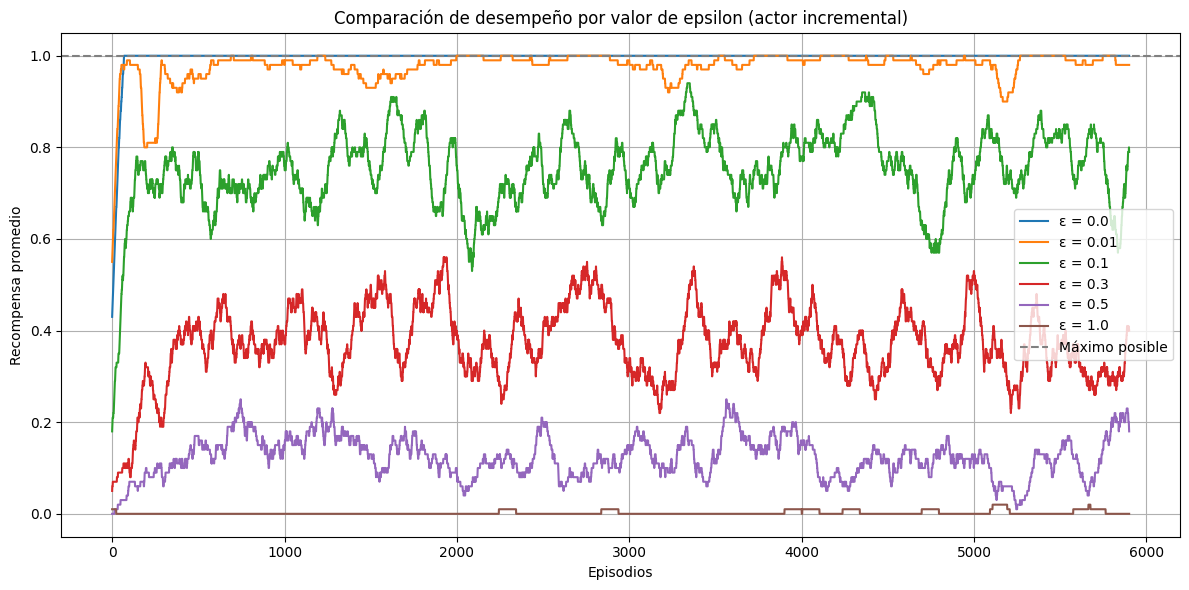

In [9]:
plt.figure(figsize=(12, 6))

for epsilon, recompensas in resultados_por_epsilon.items():
    plt.plot(media_movil(recompensas), label=f"ε = {epsilon}")

plt.axhline(y=1.0, linestyle='--', color='gray', label='Máximo posible')
plt.xlabel("Episodios")
plt.ylabel("Recompensa promedio")
plt.title("Comparación de desempeño por valor de epsilon (actor incremental)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
env_prueba = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="human")
actor_incremental = actores_incrementales[0]

estado, _ = env_prueba.reset()
terminado = False

print("\n🎮 Agente entrenado (actor incremental)\n")
time.sleep(1)

while not terminado:
    accion = actor_incremental.explotar(estado)

    siguiente_estado, recompensa, terminado, truncado, _ = env_prueba.step(accion)

    print(f"Estado {estado} → Acción {accion} → Estado {siguiente_estado} | Recompensa: {recompensa}")
    estado = siguiente_estado
    time.sleep(0.7)

env_prueba.close()



🎮 Agente entrenado (actor incremental)

Estado 0 → Acción 1 → Estado 8 | Recompensa: 0.0
Estado 8 → Acción 1 → Estado 16 | Recompensa: 0.0
Estado 16 → Acción 1 → Estado 24 | Recompensa: 0.0
Estado 24 → Acción 1 → Estado 32 | Recompensa: 0.0
Estado 32 → Acción 1 → Estado 40 | Recompensa: 0.0
Estado 40 → Acción 1 → Estado 48 | Recompensa: 0.0
Estado 48 → Acción 1 → Estado 56 | Recompensa: 0.0
Estado 56 → Acción 2 → Estado 57 | Recompensa: 0.0
Estado 57 → Acción 2 → Estado 58 | Recompensa: 0.0
Estado 58 → Acción 3 → Estado 50 | Recompensa: 0.0
Estado 50 → Acción 2 → Estado 51 | Recompensa: 0.0
Estado 51 → Acción 3 → Estado 43 | Recompensa: 0.0
Estado 43 → Acción 2 → Estado 44 | Recompensa: 0.0
Estado 44 → Acción 2 → Estado 45 | Recompensa: 0.0
Estado 45 → Acción 3 → Estado 37 | Recompensa: 0.0
Estado 37 → Acción 2 → Estado 38 | Recompensa: 0.0
Estado 38 → Acción 2 → Estado 39 | Recompensa: 0.0
Estado 39 → Acción 1 → Estado 47 | Recompensa: 0.0
Estado 47 → Acción 1 → Estado 55 | Recompens

# Valores iniciales optimistas

In [11]:
class ActorOptimista:
    def __init__(self, n_estados, n_acciones, alpha, valor_inicial):
        self.q_values = np.full((n_estados, n_acciones), valor_inicial)
        self.alpha = alpha
        self.n_acciones = n_acciones

    def seleccionar_accion(self, estado, epsilon):
        if np.random.uniform() < epsilon:
            return np.random.randint(self.n_acciones)
        q = self.q_values[estado]
        max_q = np.max(q)
        acciones_optimas = np.flatnonzero(q == max_q)
        return np.random.choice(acciones_optimas)

    def actualizar(self, estado, accion, recompensa):
        actual = self.q_values[estado, accion]
        self.q_values[estado, accion] += self.alpha * (recompensa - actual)
    
    def explotar(self, estado):
        q = self.q_values[estado]
        max_q = np.max(q)
        acciones_optimas = np.flatnonzero(q == max_q)
        return np.random.choice(acciones_optimas)

In [12]:
epsilons = [0.0, 0.01, 0.1, 0.3, 0.5, 1.0]
episodios = 6000

actores_optimistas = []
resultados_optimistas = {}

for epsilon in epsilons:
    actor = ActorOptimista(n_estados, n_acciones, alpha=0.3, valor_inicial=1.0)
    actores_optimistas.append(actor)
    lista_recompensas = []

    for episodio in range(episodios):
        estado, _ = env.reset()
        terminado = False
        visitados = set([estado])
        recompensa_total_real = 0

        while not terminado:
            accion = actor.seleccionar_accion(estado, epsilon=epsilon)
            siguiente_estado, recompensa_real, terminado, truncado, _ = env.step(accion)

            if recompensa_real == 1.0:
                recompensa = RECOMPENSAS["META"]
            elif terminado and recompensa_real == 0.0:
                recompensa = RECOMPENSAS["HUECO"]
            elif siguiente_estado == estado:
                recompensa = RECOMPENSAS["ESTANCADO"]
            elif siguiente_estado in visitados:
                recompensa = RECOMPENSAS["REPETIDO"]
            else:
                recompensa = RECOMPENSAS["AVANCE"]
                visitados.add(siguiente_estado)

            actor.actualizar(estado, accion, recompensa)
            estado = siguiente_estado
            recompensa_total_real += recompensa_real

        lista_recompensas.append(recompensa_total_real)

    resultados_optimistas[epsilon] = lista_recompensas

In [13]:
acciones = ["←", "↓", "→", "↑"]
q_table_df = pd.DataFrame(actores_optimistas[0].q_values, columns=acciones)
q_table_df.index.name = "Estado"

print("\n📋 Q-table final del actor optimista:\n")
print(q_table_df.round(2))



📋 Q-table final del actor optimista:

           ←     ↓     →     ↑
Estado                        
0      -0.38 -0.30 -0.36 -0.38
1      -0.40 -0.40 -0.30 -0.41
2      -0.39 -0.30 -0.39 -0.41
3      -0.39 -0.39 -0.39 -0.41
4      -0.39 -0.40 -0.39 -0.41
...      ...   ...   ...   ...
59      1.00  1.00  1.00  1.00
60      0.40  0.55  0.58  1.00
61      0.34  0.55  0.34  0.29
62      1.00  1.00  1.00  0.40
63      1.00  1.00  1.00  1.00

[64 rows x 4 columns]


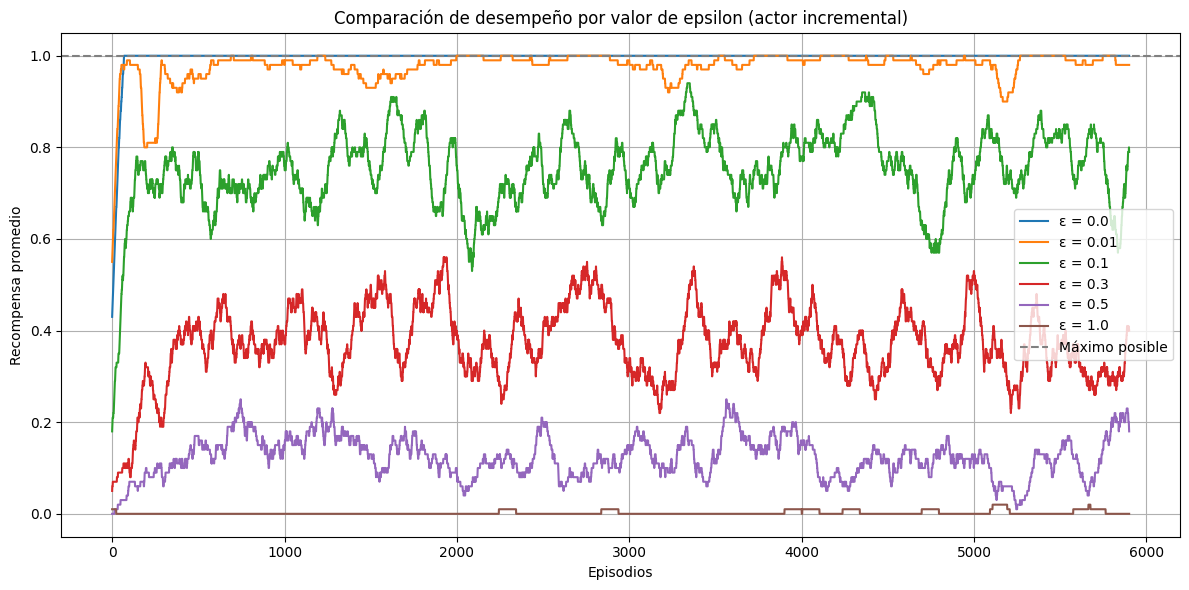

In [14]:
plt.figure(figsize=(12, 6))

for epsilon, recompensas in resultados_por_epsilon.items():
    plt.plot(media_movil(recompensas), label=f"ε = {epsilon}")

plt.axhline(y=1.0, linestyle='--', color='gray', label='Máximo posible')
plt.xlabel("Episodios")
plt.ylabel("Recompensa promedio")
plt.title("Comparación de desempeño por valor de epsilon (actor incremental)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
env_prueba = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="human")
actor_optimista = actores_optimistas[1]

estado, _ = env_prueba.reset()
terminado = False

print("\n🎮 Agente entrenado con valores iniciales optimistas\n")
time.sleep(1)

while not terminado:
    accion = actor_optimista.explotar(estado) 
    siguiente_estado, recompensa, terminado, truncado, _ = env_prueba.step(accion)
    print(f"Estado {estado} → Acción {accion} → Estado {siguiente_estado} | Recompensa: {recompensa}")
    estado = siguiente_estado
    time.sleep(0.7)

env_prueba.close()



🎮 Agente entrenado con valores iniciales optimistas

Estado 0 → Acción 1 → Estado 8 | Recompensa: 0.0
Estado 8 → Acción 2 → Estado 9 | Recompensa: 0.0
Estado 9 → Acción 1 → Estado 17 | Recompensa: 0.0
Estado 17 → Acción 0 → Estado 16 | Recompensa: 0.0
Estado 16 → Acción 1 → Estado 24 | Recompensa: 0.0
Estado 24 → Acción 1 → Estado 32 | Recompensa: 0.0
Estado 32 → Acción 2 → Estado 33 | Recompensa: 0.0
Estado 33 → Acción 2 → Estado 34 | Recompensa: 0.0
Estado 34 → Acción 3 → Estado 26 | Recompensa: 0.0
Estado 26 → Acción 2 → Estado 27 | Recompensa: 0.0
Estado 27 → Acción 2 → Estado 28 | Recompensa: 0.0
Estado 28 → Acción 1 → Estado 36 | Recompensa: 0.0
Estado 36 → Acción 2 → Estado 37 | Recompensa: 0.0
Estado 37 → Acción 2 → Estado 38 | Recompensa: 0.0
Estado 38 → Acción 2 → Estado 39 | Recompensa: 0.0
Estado 39 → Acción 1 → Estado 47 | Recompensa: 0.0
Estado 47 → Acción 1 → Estado 55 | Recompensa: 0.0
Estado 55 → Acción 1 → Estado 63 | Recompensa: 1.0


# UCB

In [16]:
class ActorUCB:
    def __init__(self, n_estados, n_acciones, alpha, c):
        self.q_values = np.zeros((n_estados, n_acciones))
        self.cuentas_accion = np.zeros((n_estados, n_acciones)) 
        self.cuentas_estado = np.zeros(n_estados)  
        self.alpha = alpha
        self.n_acciones = n_acciones
        self.c = c  # Constante de exploración

    def seleccionar_accion(self, estado):
        self.cuentas_estado[estado] += 1
        t = self.cuentas_estado[estado]

        valores_ucb = np.zeros(self.n_acciones)

        for a in range(self.n_acciones):
            q = self.q_values[estado, a]
            n = self.cuentas_accion[estado, a]
            if n == 0:
                valores_ucb[a] = np.inf  
            else:
                valores_ucb[a] = q + self.c * np.sqrt(np.log(t) / n)

        acciones_mejores = np.flatnonzero(valores_ucb == np.max(valores_ucb))
        return np.random.choice(acciones_mejores)

    def actualizar(self, estado, accion, recompensa):
        self.cuentas_accion[estado, accion] += 1
        actual = self.q_values[estado, accion]
        self.q_values[estado, accion] += self.alpha * (recompensa - actual)

    def explotar(self, estado):
        q = self.q_values[estado]
        max_q = np.max(q)
        acciones_optimas = np.flatnonzero(q == max_q)
        return np.random.choice(acciones_optimas)

In [17]:
actor_ucb = ActorUCB(n_estados, n_acciones, alpha=0.1, c=1.0)
episodios = 6000
lista_recompensas = []

for episodio in range(episodios):
    estado, _ = env.reset()
    terminado = False
    visitados = set([estado])
    recompensa_total_real = 0

    while not terminado:
        accion = actor_ucb.seleccionar_accion(estado)  
        siguiente_estado, recompensa_real, terminado, truncado, _ = env.step(accion)

        if recompensa_real == 1.0:
            recompensa = RECOMPENSAS["META"]
        elif terminado and recompensa_real == 0.0:
            recompensa = RECOMPENSAS["HUECO"]
        elif siguiente_estado == estado:
            recompensa = RECOMPENSAS["ESTANCADO"]
        elif siguiente_estado in visitados:
            recompensa = RECOMPENSAS["REPETIDO"]
        else:
            recompensa = RECOMPENSAS["AVANCE"]
            visitados.add(siguiente_estado)

        actor_ucb.actualizar(estado, accion, recompensa)
        estado = siguiente_estado
        recompensa_total_real += recompensa_real

    lista_recompensas.append(recompensa_total_real)

In [18]:
acciones = ["←", "↓", "→", "↑"]
q_table_df = pd.DataFrame(actor_ucb.q_values, columns=acciones)
q_table_df.index.name = "Estado"

print("\n📋 Q-table final del actor UCB:\n")
print(q_table_df.round(2))



📋 Q-table final del actor UCB:

           ←     ↓     →     ↑
Estado                        
0      -0.50 -0.30 -0.40 -0.50
1      -0.40 -0.40 -0.39 -0.50
2      -0.40 -0.39 -0.40 -0.50
3      -0.40 -0.40 -0.40 -0.50
4      -0.40 -0.40 -0.40 -0.50
...      ...   ...   ...   ...
59      0.00  0.00  0.00  0.00
60     -0.86 -0.50 -0.40 -0.86
61     -0.37 -0.50 -0.31 -0.40
62     -0.19 -0.20  1.00 -0.34
63      0.00  0.00  0.00  0.00

[64 rows x 4 columns]


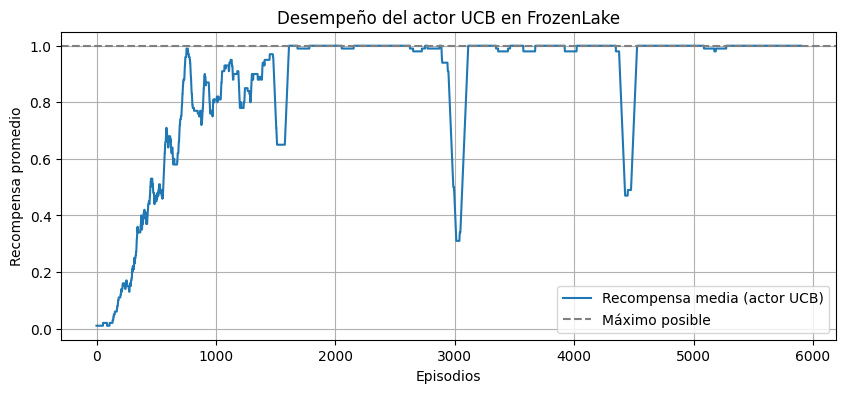

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(media_movil(lista_recompensas), label="Recompensa media (actor UCB)")
plt.axhline(y=1.0, linestyle='--', color='gray', label='Máximo posible')
plt.xlabel("Episodios")
plt.ylabel("Recompensa promedio")
plt.title("Desempeño del actor UCB en FrozenLake")
plt.legend()
plt.grid(True)
plt.show()



In [20]:
env_prueba = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="human")

estado, _ = env_prueba.reset()
terminado = False

print("\n🎮 Agente entrenado (actor UCB)...\n")
time.sleep(1)

while not terminado:
    accion = actor_ucb.explotar(estado)

    siguiente_estado, recompensa, terminado, truncado, _ = env_prueba.step(accion)

    print(f"Estado {estado} → Acción {accion} → Estado {siguiente_estado} | Recompensa: {recompensa}")
    estado = siguiente_estado
    time.sleep(0.7)

env_prueba.close()


🎮 Agente entrenado (actor UCB)...

Estado 0 → Acción 1 → Estado 8 | Recompensa: 0.0
Estado 8 → Acción 1 → Estado 16 | Recompensa: 0.0
Estado 16 → Acción 1 → Estado 24 | Recompensa: 0.0
Estado 24 → Acción 1 → Estado 32 | Recompensa: 0.0
Estado 32 → Acción 2 → Estado 33 | Recompensa: 0.0
Estado 33 → Acción 2 → Estado 34 | Recompensa: 0.0
Estado 34 → Acción 3 → Estado 26 | Recompensa: 0.0
Estado 26 → Acción 2 → Estado 27 | Recompensa: 0.0
Estado 27 → Acción 2 → Estado 28 | Recompensa: 0.0
Estado 28 → Acción 1 → Estado 36 | Recompensa: 0.0
Estado 36 → Acción 1 → Estado 44 | Recompensa: 0.0
Estado 44 → Acción 2 → Estado 45 | Recompensa: 0.0
Estado 45 → Acción 3 → Estado 37 | Recompensa: 0.0
Estado 37 → Acción 2 → Estado 38 | Recompensa: 0.0
Estado 38 → Acción 2 → Estado 39 | Recompensa: 0.0
Estado 39 → Acción 1 → Estado 47 | Recompensa: 0.0
Estado 47 → Acción 1 → Estado 55 | Recompensa: 0.0
Estado 55 → Acción 1 → Estado 63 | Recompensa: 1.0


# Algoritmos de Gradiente

In [21]:
class ActorGradiente:
    def __init__(self, n_estados, n_acciones, alpha):
        self.preferencias = np.zeros((n_estados, n_acciones))  
        self.n_acciones = n_acciones
        self.alpha = alpha
        self.historial_recompensas = []  

    def softmax(self, preferencias):
        preferencias = preferencias - np.max(preferencias) 
        exp = np.exp(preferencias)
        return exp / np.sum(exp)

    def seleccionar_accion(self, estado):
        probabilidades = self.softmax(self.preferencias[estado])
        return np.random.choice(self.n_acciones, p=probabilidades)

    def actualizar(self, estado, accion, recompensa):
        self.historial_recompensas.append(recompensa)
        promedio = np.mean(self.historial_recompensas)  # Baseline
        probabilidades = self.softmax(self.preferencias[estado])

        for a in range(self.n_acciones):
            if a == accion:
                self.preferencias[estado, a] += self.alpha * (recompensa - promedio) * (1 - probabilidades[a])
            else:
                self.preferencias[estado, a] -= self.alpha * (recompensa - promedio) * probabilidades[a]
    def explotar(self, estado):
        probabilidades = self.softmax(self.preferencias[estado])
        return np.random.choice(self.n_acciones, p=probabilidades)


In [22]:
actor_gradiente = ActorGradiente(n_estados, n_acciones, alpha=0.1)
episodios = 6000
lista_recompensas = []

for episodio in range(episodios):
    estado, _ = env.reset()
    terminado = False
    visitados = set([estado])
    recompensa_total_real = 0

    while not terminado:
        accion = actor_gradiente.seleccionar_accion(estado)
        siguiente_estado, recompensa_real, terminado, truncado, _ = env.step(accion)

        if recompensa_real == 1.0:
            recompensa = RECOMPENSAS["META"]
        elif terminado and recompensa_real == 0.0:
            recompensa = RECOMPENSAS["HUECO"]
        elif siguiente_estado == estado:
            recompensa = RECOMPENSAS["ESTANCADO"]
        elif siguiente_estado in visitados:
            recompensa = RECOMPENSAS["REPETIDO"]
        else:
            recompensa = RECOMPENSAS["AVANCE"]
            visitados.add(siguiente_estado)

        actor_gradiente.actualizar(estado, accion, recompensa)
        estado = siguiente_estado
        recompensa_total_real += recompensa_real

    lista_recompensas.append(recompensa_total_real)


In [23]:
acciones = ["←", "↓", "→", "↑"]
tabla_preferencias = pd.DataFrame(actor_gradiente.preferencias, columns=acciones)
tabla_preferencias.index.name = "Estado"

print("\n📋 Q-table final del actor Gradiente\n")
print(tabla_preferencias.round(2))


📋 Q-table final del actor Gradiente

           ←     ↓     →     ↑
Estado                        
0      -2.39  2.95  1.84 -2.40
1      -1.17  0.62  2.50 -1.94
2      -1.05  0.46  2.50 -1.91
3      -0.98  0.30  2.56 -1.88
4      -1.08  0.82  2.36 -2.10
...      ...   ...   ...   ...
59      0.00  0.00  0.00  0.00
60     -1.76  0.17  3.20 -1.61
61      0.39 -2.21  3.21 -1.39
62     -1.76 -1.89  5.76 -2.11
63      0.00  0.00  0.00  0.00

[64 rows x 4 columns]


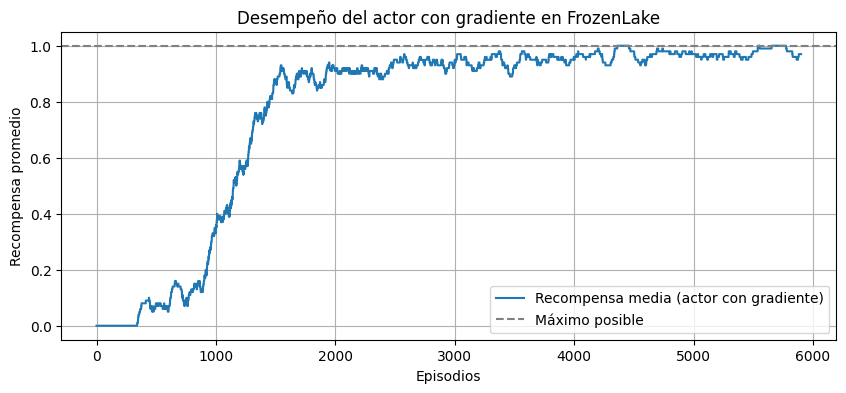

In [24]:
plt.figure(figsize=(10, 4))
plt.plot(media_movil(lista_recompensas), label="Recompensa media (actor con gradiente)")
plt.axhline(y=1.0, linestyle='--', color='gray', label='Máximo posible')
plt.xlabel("Episodios")
plt.ylabel("Recompensa promedio")
plt.title("Desempeño del actor con gradiente en FrozenLake")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
env_prueba = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="human")

estado, _ = env_prueba.reset()
terminado = False

print("\n🎮 Agente entrenado (actor gradiente)\n")
time.sleep(1)

while not terminado:
    accion = actor_gradiente.explotar(estado)  
    siguiente_estado, recompensa, terminado, truncado, _ = env_prueba.step(accion)

    print(f"Estado {estado} → Acción {accion} → Estado {siguiente_estado} | Recompensa: {recompensa}")
    estado = siguiente_estado
    time.sleep(0.7)

env_prueba.close()


🎮 Agente entrenado (actor gradiente)

Estado 0 → Acción 1 → Estado 8 | Recompensa: 0.0
Estado 8 → Acción 2 → Estado 9 | Recompensa: 0.0
Estado 9 → Acción 2 → Estado 10 | Recompensa: 0.0
Estado 10 → Acción 3 → Estado 2 | Recompensa: 0.0
Estado 2 → Acción 2 → Estado 3 | Recompensa: 0.0
Estado 3 → Acción 2 → Estado 4 | Recompensa: 0.0
Estado 4 → Acción 1 → Estado 12 | Recompensa: 0.0
Estado 12 → Acción 1 → Estado 20 | Recompensa: 0.0
Estado 20 → Acción 1 → Estado 28 | Recompensa: 0.0
Estado 28 → Acción 1 → Estado 36 | Recompensa: 0.0
Estado 36 → Acción 2 → Estado 37 | Recompensa: 0.0
Estado 37 → Acción 1 → Estado 45 | Recompensa: 0.0
Estado 45 → Acción 1 → Estado 53 | Recompensa: 0.0
Estado 53 → Acción 1 → Estado 61 | Recompensa: 0.0
Estado 61 → Acción 2 → Estado 62 | Recompensa: 0.0
Estado 62 → Acción 2 → Estado 63 | Recompensa: 1.0


Cuando se configura el entorno con (`is_slippery=True`) las acciones del agente pueden resultar en movimientos aleatorios, simulando un escenario estocástico donde el agente podría terminar en una casilla diferente a la prevista debido a la naturaleza resbaladiza del lago. Esta aleatoriedad implica que el resultado de cada acción no es completamente predecible, lo que dificulta la exploración sistemática de los estados mediante métodos puramente incrementales o de políticas optimistas. En este contexto, el método Q-learning resulta más conveniente, ya que, al incorporar el valor esperado del mejor resultado futuro (valor máximo de Q del siguiente estado), es capaz de aprender políticas robustas incluso cuando existe incertidumbre en las transiciones del entorno. Esto lo hace especialmente efectivo frente a la aleatoriedad, mientras que los otros métodos tienden a fallar o estancarse cuando el entorno no es determinista.

# Q-learning

In [31]:
env = gym.make('FrozenLake-v1', map_name='8x8', is_slippery=True)
n_estados = env.observation_space.n
n_acciones = env.action_space.n

alpha = 0.9
gamma = 0.9
epsilon = 1.0
epsilon_decay = 0.0001
episodios = 50000

recompensas_por_episodio = np.zeros(episodios)

In [32]:
class ActorQLearning:
    def __init__(self, n_estados, n_acciones, alpha, gamma):
        self.q = np.zeros((n_estados, n_acciones))
        self.alpha = alpha
        self.gamma = gamma

    def seleccionar_accion(self, estado, epsilon):
        if np.random.rand() < epsilon:
            return np.random.randint(n_acciones)
        return np.argmax(self.q[estado, :])

    def actualizar(self, estado, accion, recompensa, siguiente_estado):
        self.q[estado, accion] += self.alpha * (
            recompensa + self.gamma * np.max(self.q[siguiente_estado, :]) - self.q[estado, accion]
        )


In [33]:
actor_q = ActorQLearning(n_estados, n_acciones, alpha, gamma)

for ep in range(episodios):
    estado = env.reset()[0]
    terminado = False
    truncado = False

    while not terminado and not truncado:
        accion = actor_q.seleccionar_accion(estado, epsilon)
        siguiente_estado, recompensa, terminado, truncado, _ = env.step(accion)
        actor_q.actualizar(estado, accion, recompensa, siguiente_estado)
        estado = siguiente_estado

    epsilon = max(epsilon - epsilon_decay, 0)
    if epsilon == 0:
        actor_q.alpha = 0.0001

    if recompensa == 1.0:
        recompensas_por_episodio[ep] = 1


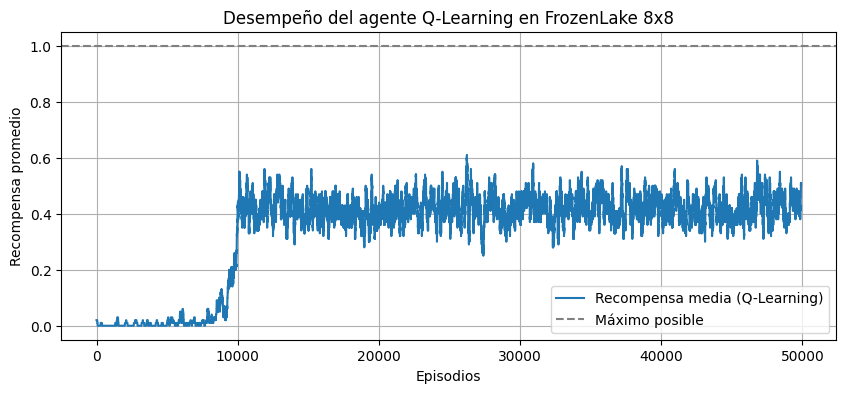

In [34]:
plt.figure(figsize=(10, 4))
plt.plot(media_movil(recompensas_por_episodio, 100), label="Recompensa media (Q-Learning)")
plt.axhline(y=1.0, linestyle='--', color='gray', label='Máximo posible')
plt.xlabel("Episodios")
plt.ylabel("Recompensa promedio")
plt.title("Desempeño del agente Q-Learning en FrozenLake 8x8")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True, render_mode="human")
estado, _ = env.reset()
terminado = False

print("\n🎮 Agente entrenado (Q-Learning) \n")
time.sleep(1)

while not terminado:
    accion = np.argmax(actor_q.q[estado])
    siguiente_estado, recompensa, terminado, truncado, _ = env.step(accion)
    print(f"Estado {estado} → Acción {accion} → Estado {siguiente_estado} | Recompensa: {recompensa}")
    estado = siguiente_estado
    time.sleep(0.7)

env.close()



🎮 Agente entrenado (Q-Learning) 

Estado 0 → Acción 1 → Estado 0 | Recompensa: 0.0
Estado 0 → Acción 1 → Estado 0 | Recompensa: 0.0
Estado 0 → Acción 1 → Estado 0 | Recompensa: 0.0
Estado 0 → Acción 1 → Estado 0 | Recompensa: 0.0
Estado 0 → Acción 1 → Estado 8 | Recompensa: 0.0
Estado 8 → Acción 2 → Estado 0 | Recompensa: 0.0
Estado 0 → Acción 1 → Estado 1 | Recompensa: 0.0
Estado 1 → Acción 3 → Estado 2 | Recompensa: 0.0
Estado 2 → Acción 2 → Estado 2 | Recompensa: 0.0
Estado 2 → Acción 2 → Estado 3 | Recompensa: 0.0
Estado 3 → Acción 2 → Estado 4 | Recompensa: 0.0
Estado 4 → Acción 2 → Estado 12 | Recompensa: 0.0
Estado 12 → Acción 1 → Estado 13 | Recompensa: 0.0
Estado 13 → Acción 2 → Estado 5 | Recompensa: 0.0
Estado 5 → Acción 3 → Estado 5 | Recompensa: 0.0
Estado 5 → Acción 3 → Estado 4 | Recompensa: 0.0
Estado 4 → Acción 2 → Estado 4 | Recompensa: 0.0
Estado 4 → Acción 2 → Estado 12 | Recompensa: 0.0
Estado 12 → Acción 1 → Estado 11 | Recompensa: 0.0
Estado 11 → Acción 3 → Esta